In [1]:
import numpy as np 
import scipy
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris
import pandas as pd
from seaborn import pairplot
from typing import Tuple
from sklearn.cluster import KMeans

# Exercise 3: Gaussian Mixture Model EM-Algorithm

In this notebook we will implement the EM-Algorithm for GMMs and apply it to "real" dataset: Iris. This is perhaps the best known dataset in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. The are four features, the sepal length in cm the sepal width in cm, the petal length in cm and the petal width in cm. 

The next two cells will load the dataset into the notebook.

In [2]:
# Data as dataframe
data = load_iris(as_frame=True)

df_X = data["data"]
df_y = data["target"]

# Train data in numpy arrays
X = df_X.to_numpy()
y = df_y.to_numpy()

# Dataset in a df for plotting
df = pd.concat([df_X, df_y], axis=1)

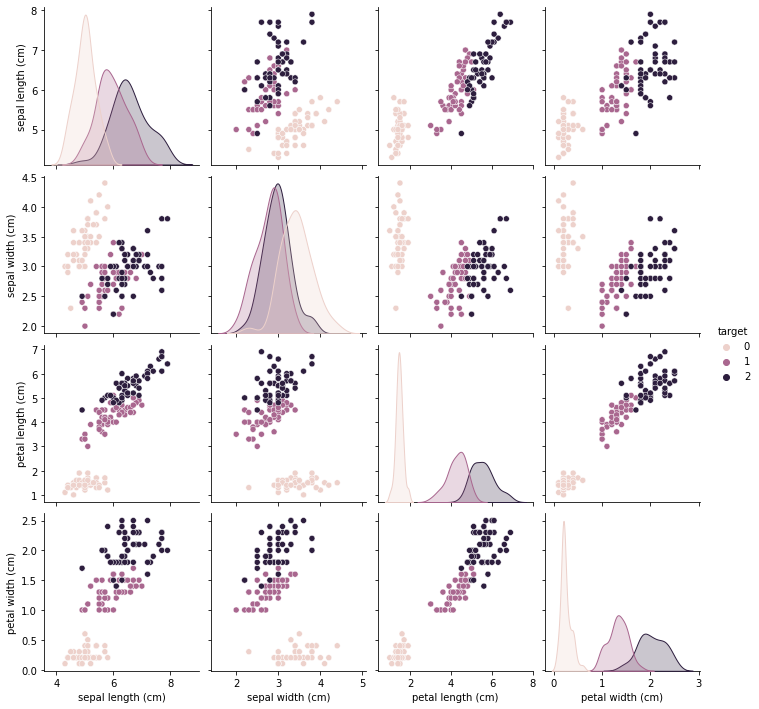

In [4]:
%matplotlib inline
pairplot(df, hue="target")

Based on the above pairplot one can already guess that a Gaussian Mixture model can nicely model this data, so let's do that!

## Exercise 3.1

Here we will implement the E-step and M-step as functions. You already derived all the formulas for the EM algorithm by yourself in Exercise 2. Here are the solutions you should have arrived at:

### E-step

This requires to compute
$$ r_{ij} = \frac{\pi_j^{old} \mathcal{N}(x_i; \mu_j^{old}, \Sigma_j^{old})}{\sum_{j=1}^k \pi_j^{old} \mathcal{N}(x_i; \mu_j^{old}, \Sigma_j^{old})} $$
for each datapoint. This equals the posterior probabilities of cluster assignments given the current parameter candidates. 

**NOTE**: For numerical stability, you may want to perform most computations in log-space and perform normalization using the "logsumexp" trick (i.e. using np.logsumexp). 

### M-step 

The maximization is possible in closed form, and given by:

$$R_j = \sum_{i=1}^nr_{ij} \qquad   \pi_j = \frac{R_j}{n} \qquad \mu_j = \frac{1}{R_j}\sum_{i=1}^n r_{ij}x_i \qquad \Sigma_j = \frac{1}{R_j} \sum_{i=1}^n r_{ij}(x_i-\mu_j) (x_i-\mu_j)^T$$

**NOTE**: There are some numerical considerations
* In theory $r_{ij} \neq 0$ for all $j, i$. Yet in practise, we use floating point numbers which have limited precision. As a result e.g. $R_j$ can be zero if all datapoints are far away from a cluster, which would lead to a division by zero.
* The covariance matrix should be symmetric postive definite. It may be required to ensure this i.e. by adding a small value to the diagonals.

In [5]:
# Some variables you may want to use
n = X.shape[0] # Number of samples
d = X.shape[1] # Dimensionality of each sample

# Here we know the number of clusters, there are only 3 types of iris plants in the data.
k = 3

In [6]:
def E_step(X, pi, mu, cov) -> np.array:
    """
    Perform the E step

    args:
        X (n, d): data, n samples of dimensionality d
        pi (k): mixture weights of Gaussians
        mu (k,d): means of Gaussians
        cov (k,d,d): covariances of Gaussians
    returns:
        r (n,k): posterior probability for cluster assignments
                     for each datatpoint
    """ 
    n = X.shape[0]  # Number of samples
    d = X.shape[1]  # Dimensionality of each sample
    k = pi.shape[0] # number of clusters
    
    r = np.zeros((n,k))
    
    for i, x_i in enumerate(X):
        norm = np.sum([pi[j] * scipy.stats.multivariate_normal.pdf(x_i, mean=mu[j], cov=cov[j]) for j in range(k)])
        for j in range(k):
            g = scipy.stats.multivariate_normal.pdf(x_i, mean=mu[j], cov=cov[j])
            r[i,j] = (pi[j]*g) / norm
    return r

In [7]:
# Test for correctness: 
test1 = E_step(X, np.array([1/3, 1/3, 1/3]), np.ones((3,4)), [np.eye(4) for k in range(3)])
test2 = E_step(X, np.array([1/3, 1/3, 1/3]), np.array([[-1.,0.,3., 0.], [0.,2.,0., 1.], [5.,5.,5.,5.]]), [np.eye(4) for k in range(3)])
assert test1.shape[0] == n, "The first dimension should be of shape N"
assert test1.shape[1] == k, "The second dimension should be of shape K"
assert np.isclose(test1.mean(0), np.array([1/3, 1/3, 1/3]), atol=1e-2, rtol=1e-2).all(), "If all clusters are the same, the posterior probabilities should be uniform."
assert np.isclose(test2.mean(0), np.array([2.93392254e-05, 2.85799805e-01, 7.14170855e-01]), atol=1e-2, rtol=1e-2).all(), "There is something wrong :("

In [8]:
def M_step(r, X) -> Tuple[np.array, np.array, np.array]:
    """
    Maximize expectation of complete data log likelihood
    
    args:
        r (n,k): posterior probability for cluster assignments
                     for each datatpoint
    returns:
        X (n, d): data, n samples of dimensionality d
        pi (k): mixture weights of Gaussians
        mu (k,d): means of Gaussians
        cov (k,d,d): covariances of Gaussians
    """ 
    n = X.shape[0]  # Number of samples
    d = X.shape[1]  # Dimensionality of each sample
    k = r.shape[1]  # number of clusters
    
    R = r.sum(axis=0)
    assert R.shape == (k,), f"{R.shape}"
    
    pi = R / n
    assert pi.shape == (k,)
   
    mu = np.zeros((k,d))
    covs = np.zeros((k,d,d))
    for j in range(k):
        mu[j] = np.sum([r[i,j] * x_i for i, x_i in enumerate(X)], axis=0) * (1/R[j])
        covs[j] = np.sum([r[i,j] * np.outer((x_i-mu[j]),(x_i-mu[j])) for i, x_i in enumerate(X)], axis=0) * (1/R[j])

    return pi, mu, covs

In [9]:
# Test for correctness
pi_test1, mu_test1, cov_test1 = M_step(test1, X)
assert pi_test1.shape[0] == k, "There should be one mixture coefficient for each cluster K."
assert mu_test1.shape[0] == k and mu_test1.shape[1] == d, "The shape of the cluster means should be (K, d)."
assert cov_test1.shape[0] == k and cov_test1.shape[1] == d and cov_test1.shape[2] == d, "The shape of the cluster covariance matrices should be (K,d,d)"
assert np.isclose(pi_test1.sum(), 1., atol=1e-3, rtol=1e-3), "The mixture coefficients must sum to one."
assert all([np.all(np.linalg.eigvalsh(cov_test1[j]) > 0.) for j in range(k)]), "The estimated covariance matrix is not positive definite"
assert np.isclose(pi_test1, np.array([1/3, 1/3, 1/3]), atol=1e-2, rtol=1e-2).all() and np.isclose(mu_test1.mean(0), np.array([5.84333333, 3.05733333, 3.758     , 1.19933333]), atol=1e-2, rtol=1e-2).all() and np.isclose(cov_test1.mean(), 0.6058022499999997, atol=1e-2, rtol=1e-2) , "Something went wrong :("

## Exercise 3.2 

While not required for the algorithm, it is a good idea to compute the total data negative loglikelihood. Recall that for a Gaussian Mixture model this is given by

$$ -\ln p(x) =-\sum_{i=1}^n \ln \sum_{j=1}^k \pi_j \mathcal{N}(x_i; \mu_j, \Sigma_j) $$

**NOTE**: As we saw in the EXAMple question each iteration must decrease the negative loglikelihood.

In [10]:
def negativeloglikelihood(X, pi, mu, cov) -> float:
    """
    Computes the marginal negative log likelihood.
    
    args:
        X (n, d): data, n samples of dimensionality d
        pi (k): mixture weights of Gaussianss
        mu (k,d): means of Gaussians
        cov (k,d,d): covariances of Gaussians
    """ 
    n = X.shape[0]  # Number of samples
    d = X.shape[1]  # Dimensionality of each sample
    k = pi.shape[0] # number of clusters
    
    logll = 0
    for x_i in X:
        logll += np.log(np.sum([pi[j] * scipy.stats.multivariate_normal.pdf(x_i, mean=mu[j], cov=cov[j]) for j in range(k)]))
        
    return -logll

In [11]:
# Test for correctness
assert np.isclose(negativeloglikelihood(X, pi_test1, mu_test1, cov_test1), 379.914630122269, atol=1e-2, rtol=1e-2), "Something is wrong :("

## Exercise 3.3

Implement an initialization scheme. As you learned in the lecture, EM will only converge to a **local** extrema. Thus to find a good solution you should implement a good initialization or run the algorithm multiple times on different random initializations.

Here we provide some suggestions, but you are free to try out your own initializations!
* You can use a simple clustering algorithm e.g. KMeans to find good initializations. Be free to use any implementation you want, e.g. from sklearn (already imported).
* You can derive one from the data. 
* You can use a random initialization. Note if it is "bad" then you may run into numerical issues.

In [12]:
def init_params():
    """
   Some initialization scheme
   
   returns:
        pi (k): mixture weights of Gaussians
        mu (k,d): means of Gaussians
        cov (k,d,d): covariances of Gaussians
    """ 
    n = X.shape[0]
    d = X.shape[1]
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    
    pi = counts/n
    
    mu=kmeans.cluster_centers_
    
    cov = np.zeros((k,d,d))
    for j, label in enumerate(labels):
        cov[j] = np.cov(X[kmeans.labels_==label].T)
    
    return pi, mu, cov

In [13]:
# Some tests for correctness
pi_test2, mu_test2, cov_test2 = init_params()
assert np.isclose(pi_test2.sum(), 1., atol=1e-3, rtol=1e-3), "The mixture coefficients must sum to one."
assert all([np.all(np.linalg.eigvalsh(cov_test2[j]) > 0.) for j in range(k)]), "The estimated covariance matrix is not positive definite"

## Exercise 3.5

Implement the EM algorithm using the functions you just implemented above.

Run the algorithm on the data, the following cells should plot the "loss" history. Recall, if everything works this should be monotonically decreasing.

In [15]:
def fit(pi, mu, cov, iters=50):
    """
    
    A function that runs the EM algorithm.

    args:
        pi (k): Initial mixture coefficients.
        mu (k,d): Initial cluster means.
        cov (k,d,d): Initial cluster covariance matrices.
        iters (int, optional): Number of iterations. Defaults to 50.

    returns:
        pi (k): Final mixture coefficients.
        mu (k,d): Final cluster means.
        cov (k,d,d): Final cluster covariance matrices.
        loss_hist: A list containing the negative loglikelihoods 
                   at each iteration
    """
    loss_hist = np.zeros((iters,))
    for i in range(iters):
        r = E_step(X, pi, mu, cov)
        pi, mu, cov = M_step(r, X)
        loss_hist[i] = negativeloglikelihood(X, pi, mu, cov)


    return pi, mu, cov, loss_hist

In [16]:
pi, mu, cov, loss = fit(*init_params())

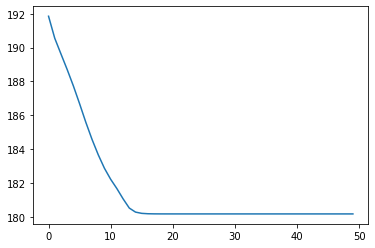

In [17]:
plt.plot(loss)


## Exercise 3.7

Note that for now, we did not use the labels $y$. This is because our probabilistic model is *unsupervised*. We assume there is an underlying "clustered" structure but pretend we don't know it. This raises the question if we did recover the ground truth labels.

To test this, predict and plot the most likely cluster assignments for the data.

**NOTE** You already implemented the functions you require to do this.

Compere it to the plot on top using the ground truth cluster assignments. Does it recover the truth? If not, give some reasons why the approach may failed.

In [18]:
probs = E_step(X, pi, mu, cov)
predictions = probs.argmax(axis=1)
# The predictions should be an array of length n containing either 0,1 or 2.
df["predictions"] = predictions

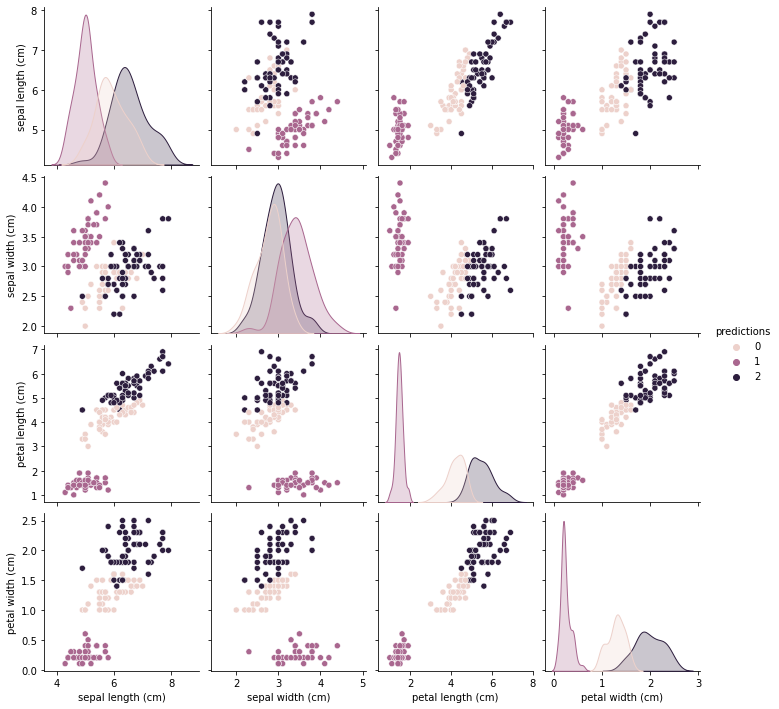

In [19]:
pairplot(df.drop("target", axis=1), hue="predictions")

### You can also compare your own implementation to Sklearn's
You could compare your own implementation to Sklearn's. This library uses K means as initialisation, so in case you used a different scheme, your results might look different!

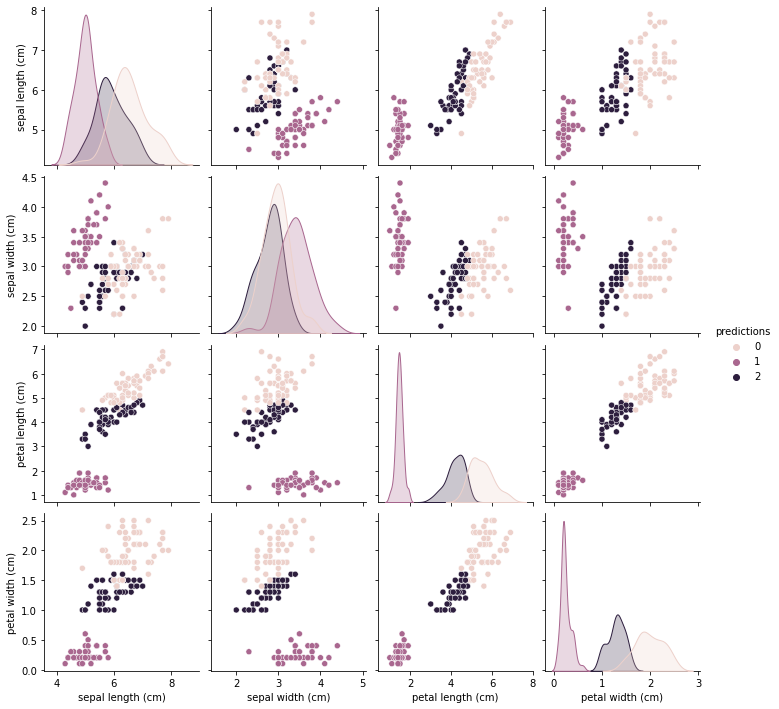

In [20]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

predictions = gmm.predict(X)

# The predictions should be an array of length N containing either 0,1 or 2.
df["predictions"] = predictions
pairplot(df.drop("target", axis=1), hue="predictions")